In [1]:
import socket
import spynnaker8 as sp8
from pyNN.random import NumpyRNG, RandomDistribution
from pyNN.utility.plotting import Figure, Panel
import matplotlib.pyplot as plt
import pdb
import os
import time
import numpy as np
from numpy import genfromtxt

import sys
sys.path.insert(1, '../../miscelaneous')
from spinnorse_tools import fetch_files, plot_iho

Detected PyNN version 0.9.4 and Neo version 0.6.1


In [2]:
dt = 1           # (ms) simulation timestep

cell_params = {'tau_m': 20.0,
               'tau_syn_E': 5.0,
               'tau_syn_I': 5.0,
               'v_rest': -65.0,
               'v_reset': -65.0,
               'v_thresh': -50.0,
               'tau_refrac': 0.0, # 0.1 originally
               'cm': 1,
               'i_offset': 0.0
               }

w_ih = 0.02
w_ho = 1

In [3]:
#SpiNNaker Setup
delay = 2*dt
nb_steps = 400
node_id = sp8.setup(timestep=dt, min_delay=delay, max_delay=delay)     
celltype = sp8.IF_curr_exp
sp8.set_number_of_neurons_per_core(celltype, 10) #  100 neurons per core

nb_hl = 1
ratio = 4
nb_nol = 1
nb_nhl = nb_nol*(ratio**(nb_hl))
nb_nil = nb_nol*(ratio**(nb_hl+1))

# Fetch available trains of spikes in path
path = "input/"
files = fetch_files(path)

# Stack Spike Trains
spike_trains = np.zeros((nb_steps,nb_nil))
for i in range(nb_nil):
    try:
        spike_trains[:,i] = genfromtxt(files[i], delimiter=',')
    except:
        print("spikes_%02d.csv not available " % (i+1))
        

2021-01-05 15:23:14 INFO: Read cfg files: /home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/jprb/.spynnaker.cfg
2021-01-05 15:23:14 INFO: Will search these locations for binaries: /home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/common_model_binaries : /home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/model_binaries
2021-01-05 15:23:14 INFO: Setting time scale factor to 1.
2021-01-05 15:23:14 INFO: Setting machine time step to 1000 micro-seconds.


['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']


In [4]:
# Create Populations
fcnn_i = []
for i in range(nb_nil):
    i_indexes = np.asarray(np.where(spike_trains[:,i]>0)).reshape(-1)
    fcnn_i.append(sp8.Population(nb_nil,sp8.SpikeSourceArray(spike_times=(i_indexes))))

fcnn_h = []
for i in range(nb_nhl):
    pop_name = "fcnn_h_" + str(i)
    fcnn_h.append(sp8.Population(1, celltype(**cell_params), label=pop_name))

fcnn_o = []
for i in range(nb_nol):
    pop_name = "fcnn_o_" + str(i)
    fcnn_o.append(sp8.Population(1, celltype(**cell_params), label=pop_name))
    


In [5]:
# Setup Connectivity
con = sp8.AllToAllConnector()

syn = sp8.StaticSynapse(weight=w_ih, delay=0)
for i in range(nb_nil):
    print("fcnn_i[%d] --> fcnn_h[%d]" % (i, int(i/ratio)))
    sp8.Projection(fcnn_i[i], fcnn_h[int(i/ratio)], con, receptor_type='excitatory', synapse_type=syn)

syn = sp8.StaticSynapse(weight=w_ho, delay=0)    
for i in range(nb_nhl):
    print("fcnn_h[%d] --> fcnn_o[%d]" % (i, int(i/ratio)))
    sp8.Projection(fcnn_h[i], fcnn_o[int(i/ratio)], con, receptor_type='excitatory', synapse_type=syn)

# Record Voltages and Spikes
for i in range(nb_nil):
    fcnn_i[i].record(["spikes"])
for i in range(nb_nhl):
    fcnn_h[i].record(["v","spikes"])
for i in range(nb_nol):
    fcnn_o[i].record(["v","spikes"])


fcnn_i[0] --> fcnn_h[0]
fcnn_i[1] --> fcnn_h[0]
fcnn_i[2] --> fcnn_h[0]
fcnn_i[3] --> fcnn_h[0]
fcnn_i[4] --> fcnn_h[1]
fcnn_i[5] --> fcnn_h[1]
fcnn_i[6] --> fcnn_h[1]
fcnn_i[7] --> fcnn_h[1]
fcnn_i[8] --> fcnn_h[2]
fcnn_i[9] --> fcnn_h[2]
fcnn_i[10] --> fcnn_h[2]
fcnn_i[11] --> fcnn_h[2]
fcnn_i[12] --> fcnn_h[3]
fcnn_i[13] --> fcnn_h[3]
fcnn_i[14] --> fcnn_h[3]
fcnn_i[15] --> fcnn_h[3]
fcnn_h[0] --> fcnn_o[0]
fcnn_h[1] --> fcnn_o[0]
fcnn_h[2] --> fcnn_o[0]
fcnn_h[3] --> fcnn_o[0]


In [6]:
# Start Simulation
sp8.run(nb_steps)

# Get recorded data
i_spikes = np.zeros((nb_steps,nb_nil))
for i in range(nb_nil):
    indexes = np.asarray(fcnn_i[i].get_data("spikes").segments[0].spiketrains[0]).astype(int).reshape(-1)
    np.put(i_spikes[:,i],indexes, np.ones(indexes.shape[0]))
    
o_spikes_hl = np.zeros((nb_steps,nb_nhl))
v_hl = np.zeros((nb_steps,nb_nhl))
for i in range(nb_nhl):
    indexes = np.asarray(fcnn_h[i].get_data("spikes").segments[0].spiketrains[0]).astype(int).reshape(-1)
    np.put(o_spikes_hl[:,i],indexes, np.ones(indexes.shape[0]))
    v_hl[:,i] = np.asarray(fcnn_h[i].get_data("v").segments[0].filter(name="v")[0]).reshape(-1)
    
o_spikes_ol = np.zeros((nb_steps,nb_nol))
v_ol = np.zeros((nb_steps,nb_nol))
for i in range(nb_nol):
    indexes = np.asarray(fcnn_o[i].get_data("spikes").segments[0].spiketrains[0]).astype(int).reshape(-1)
    np.put(o_spikes_ol[:,i],indexes, np.ones(indexes.shape[0]))
    v_ol[:,i] = np.asarray(fcnn_o[i].get_data("v").segments[0].filter(name="v")[0]).reshape(-1)
    
# End Simulation
sp8.end()

2021-01-05 15:23:21 INFO: Simulating for 400 1.0ms timesteps using a hardware timestep of 1000us
2021-01-05 15:23:21 INFO: Starting execution process
2021-01-05 15:23:21 INFO: Creating transceiver for 192.168.240.1
2021-01-05 15:23:21 INFO: Working out if machine is booted
2021-01-05 15:23:25 INFO: Attempting to boot machine
2021-01-05 15:23:34 INFO: Attempting to boot machine
2021-01-05 15:23:40 INFO: Found board with version [Version: SC&MP 3.2.5 at SpiNNaker:0:0:0 (built Thu Aug  1 10:15:06 2019)]
2021-01-05 15:23:40 INFO: Machine communication successful
2021-01-05 15:23:40 INFO: Detected a machine on IP address 192.168.240.1 which has 858 cores and 120.0 links
2021-01-05 15:23:40 INFO: Time 0:00:18.667620 taken by MachineGenerator
Pre allocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2021-01-05 15:23:40 INFO: Time 0:00:00.033005 taken by PreAllocateResourcesForExtraMonitorSupport
2021-01-05 15:23:40 INFO: Time 0:

2021-01-05 15:23:52 INFO: Time 0:00:06.729782 taken by LoadSystemExecutableImages
Clearing tags
|0%                          50%                         100%|
Loading Tags
|0%                          50%                         100%|
2021-01-05 15:23:52 INFO: Time 0:00:00.016036 taken by TagsLoader
Writing data
|0%                          50%                         100%|
2021-01-05 15:23:52 INFO: Time 0:00:00.027270 taken by WriteMemoryIOData
Executing data specifications and loading data for application vertices
|0%                          50%                         100%|
2021-01-05 15:23:55 INFO: Time 0:00:02.188213 taken by HostExecuteApplicationDataSpecification
Expanding Synapses
|0%                          50%                         100%|
2021-01-05 15:23:58 INFO: Time 0:00:03.764778 taken by SynapseExpander
Writing fixed route report
|0%                          50%                         100%|
2021-01-05 15:23:58 INFO: Time 0:00:00.029047 taken by FixedRouteFromMachineR

Getting v for fcnn_h_0
|0%                          50%                         100%|
2021-01-05 15:24:08 WARNING: Warning getting data on a whole population when selective recording is active will result in only the requested neurons being returned in numerical order and without repeats.
Getting spikes for fcnn_h_1
|0%                          50%                         100%|
Getting v for fcnn_h_1
|0%                          50%                         100%|
Getting spikes for fcnn_h_2
|0%                          50%                         100%|
Getting v for fcnn_h_2
|0%                          50%                         100%|
Getting spikes for fcnn_h_3
|0%                          50%                         100%|
Getting v for fcnn_h_3
|0%                          50%                         100%|
Getting spikes for fcnn_o_0
|0%                          50%                         100%|
Getting v for fcnn_o_0
|0%                          50%                         100%|


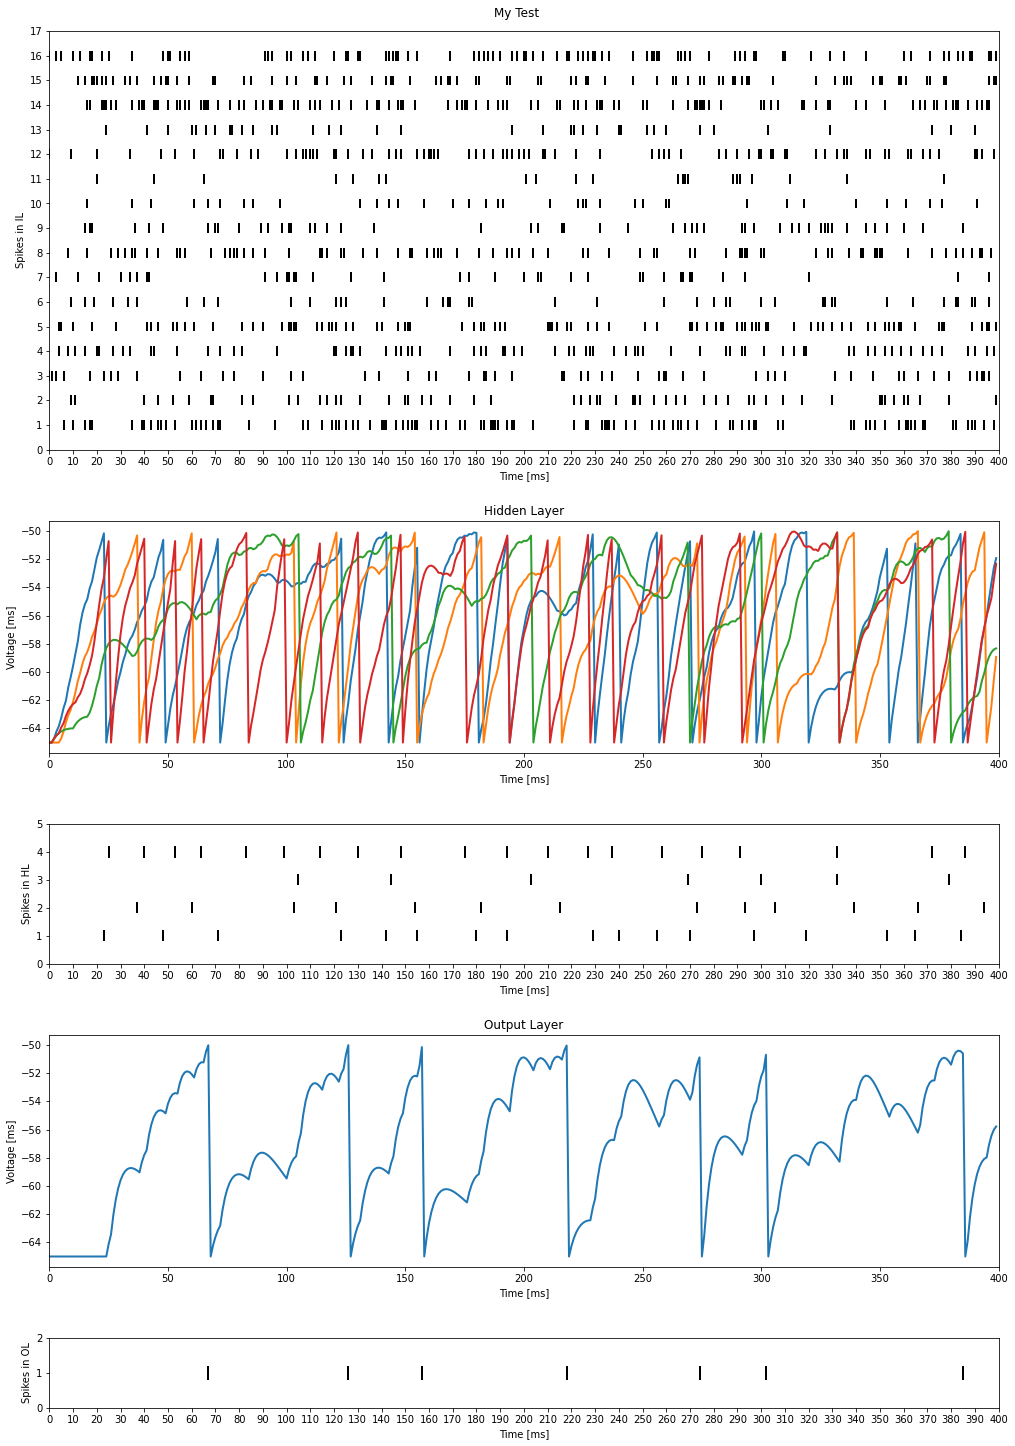

In [7]:
# Plot Stuff
sfn = "My Test"
plot_iho(i_spikes, o_spikes_hl, v_hl, o_spikes_ol, v_ol, sfn, nb_steps, ratio)

In [ ]:
# max(v_hl[0:nb_steps,:])

In [ ]:
# max(v_ol[0:nb_steps,:])